In [1]:
from glob import glob
import os

import cv2
import numpy as np
import torch
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from tqdm import tqdm
from scoring import *
from border_and_title import *
from template_extraction import *

In [2]:
# files = [
#     "../../data/original/Good/300-014820.pdf",
#     "../../data/original/Good/300-014823.pdf",
#     "../../data/original/Good/300-014821.pdf",
#     "../../data/original/Good/300-014822.pdf"
# ]
# files = [
#     "../../data/original/Good/300CRL002.png",
#     "../../data/original/Good/300CRL010.png",
# ]
# files = [
#     "../../data/original/Ugly/000.000.537.pdf",
#     "../../data/original/Ugly/000.001.296.pdf",
#     "../../data/original/Ugly/000.001.360.pdf",
#     "../../data/original/Ugly/000.001.389.pdf",
#     "../../data/original/Ugly/000.895.652.pdf",
#     # "../../data/original/Ugly/000.895.659.pdf",
#     # "../../data/original/Ugly/000.895.681.pdf",
#     # "../../data/original/Ugly/000.895.684.pdf",
#     # "../../data/original/Ugly/000.895.701 (1).pdf"
# ]
# files = [
#     "../../data/original/Ugly/000.001.024.pdf",
#     "../../data/original/Ugly/000.001.303.pdf",
#     "../../data/original/Ugly/000.001.373.pdf",
#     "../../data/original/Ugly/000.001.423.pdf",
#     "../../data/original/Ugly/000.895.692.pdf",
# ]
# files = [
#     "../../data/original/Ugly/1.pdf",
#     "../../data/original/Ugly/2.pdf",
#     "../../data/original/Ugly/3.pdf",
#     "../../data/original/Ugly/4.pdf",
#     "../../data/original/Ugly/5.pdf",
#     "../../data/original/Ugly/6.pdf",
#     "../../data/original/Ugly/7.pdf",
#     "../../data/original/Ugly/8.pdf",
#     "../../data/original/Ugly/9.pdf",
#     "../../data/original/Ugly/10.pdf",
#     "../../data/original/Ugly/11.pdf"
# ]
# files = [
#     "../../data/original/Good/15316-100-D-006_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-020_Sheet2.pdf",
#     "../../data/original/Good/15316-100-D-040_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-041_Sheet1.pdf"
# ]
files = [
    "../../data/original/Good/15316-100-D-006_Sheet1.pdf",
    "../../data/original/Good/15316-100-D-020_Sheet2.pdf"
]

In [3]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

progress = tqdm(total=len(files), desc="Processing Input", leave=True, position=0)
structures = []
image_data = []
for f in files:
    img = read_pdf(f)

    sorted_indices, contours, hierarchy_area = detect_objects(img)
    title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
    ocr_result = data["ocr_result"]
    mask = data["mask"]
    inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
    structures.append(mask)
    image_data.append([f, img, ocr_result, inner_border_lines, title_contours, line_90, sorted_indices, contours, hierarchy_area])
    progress.update()

borders, template = get_template_borders_from_structures(structures)

Processing Input: 100%|██████████| 2/2 [00:02<00:00,  1.01it/s]

Image Similarity: 93.8496%


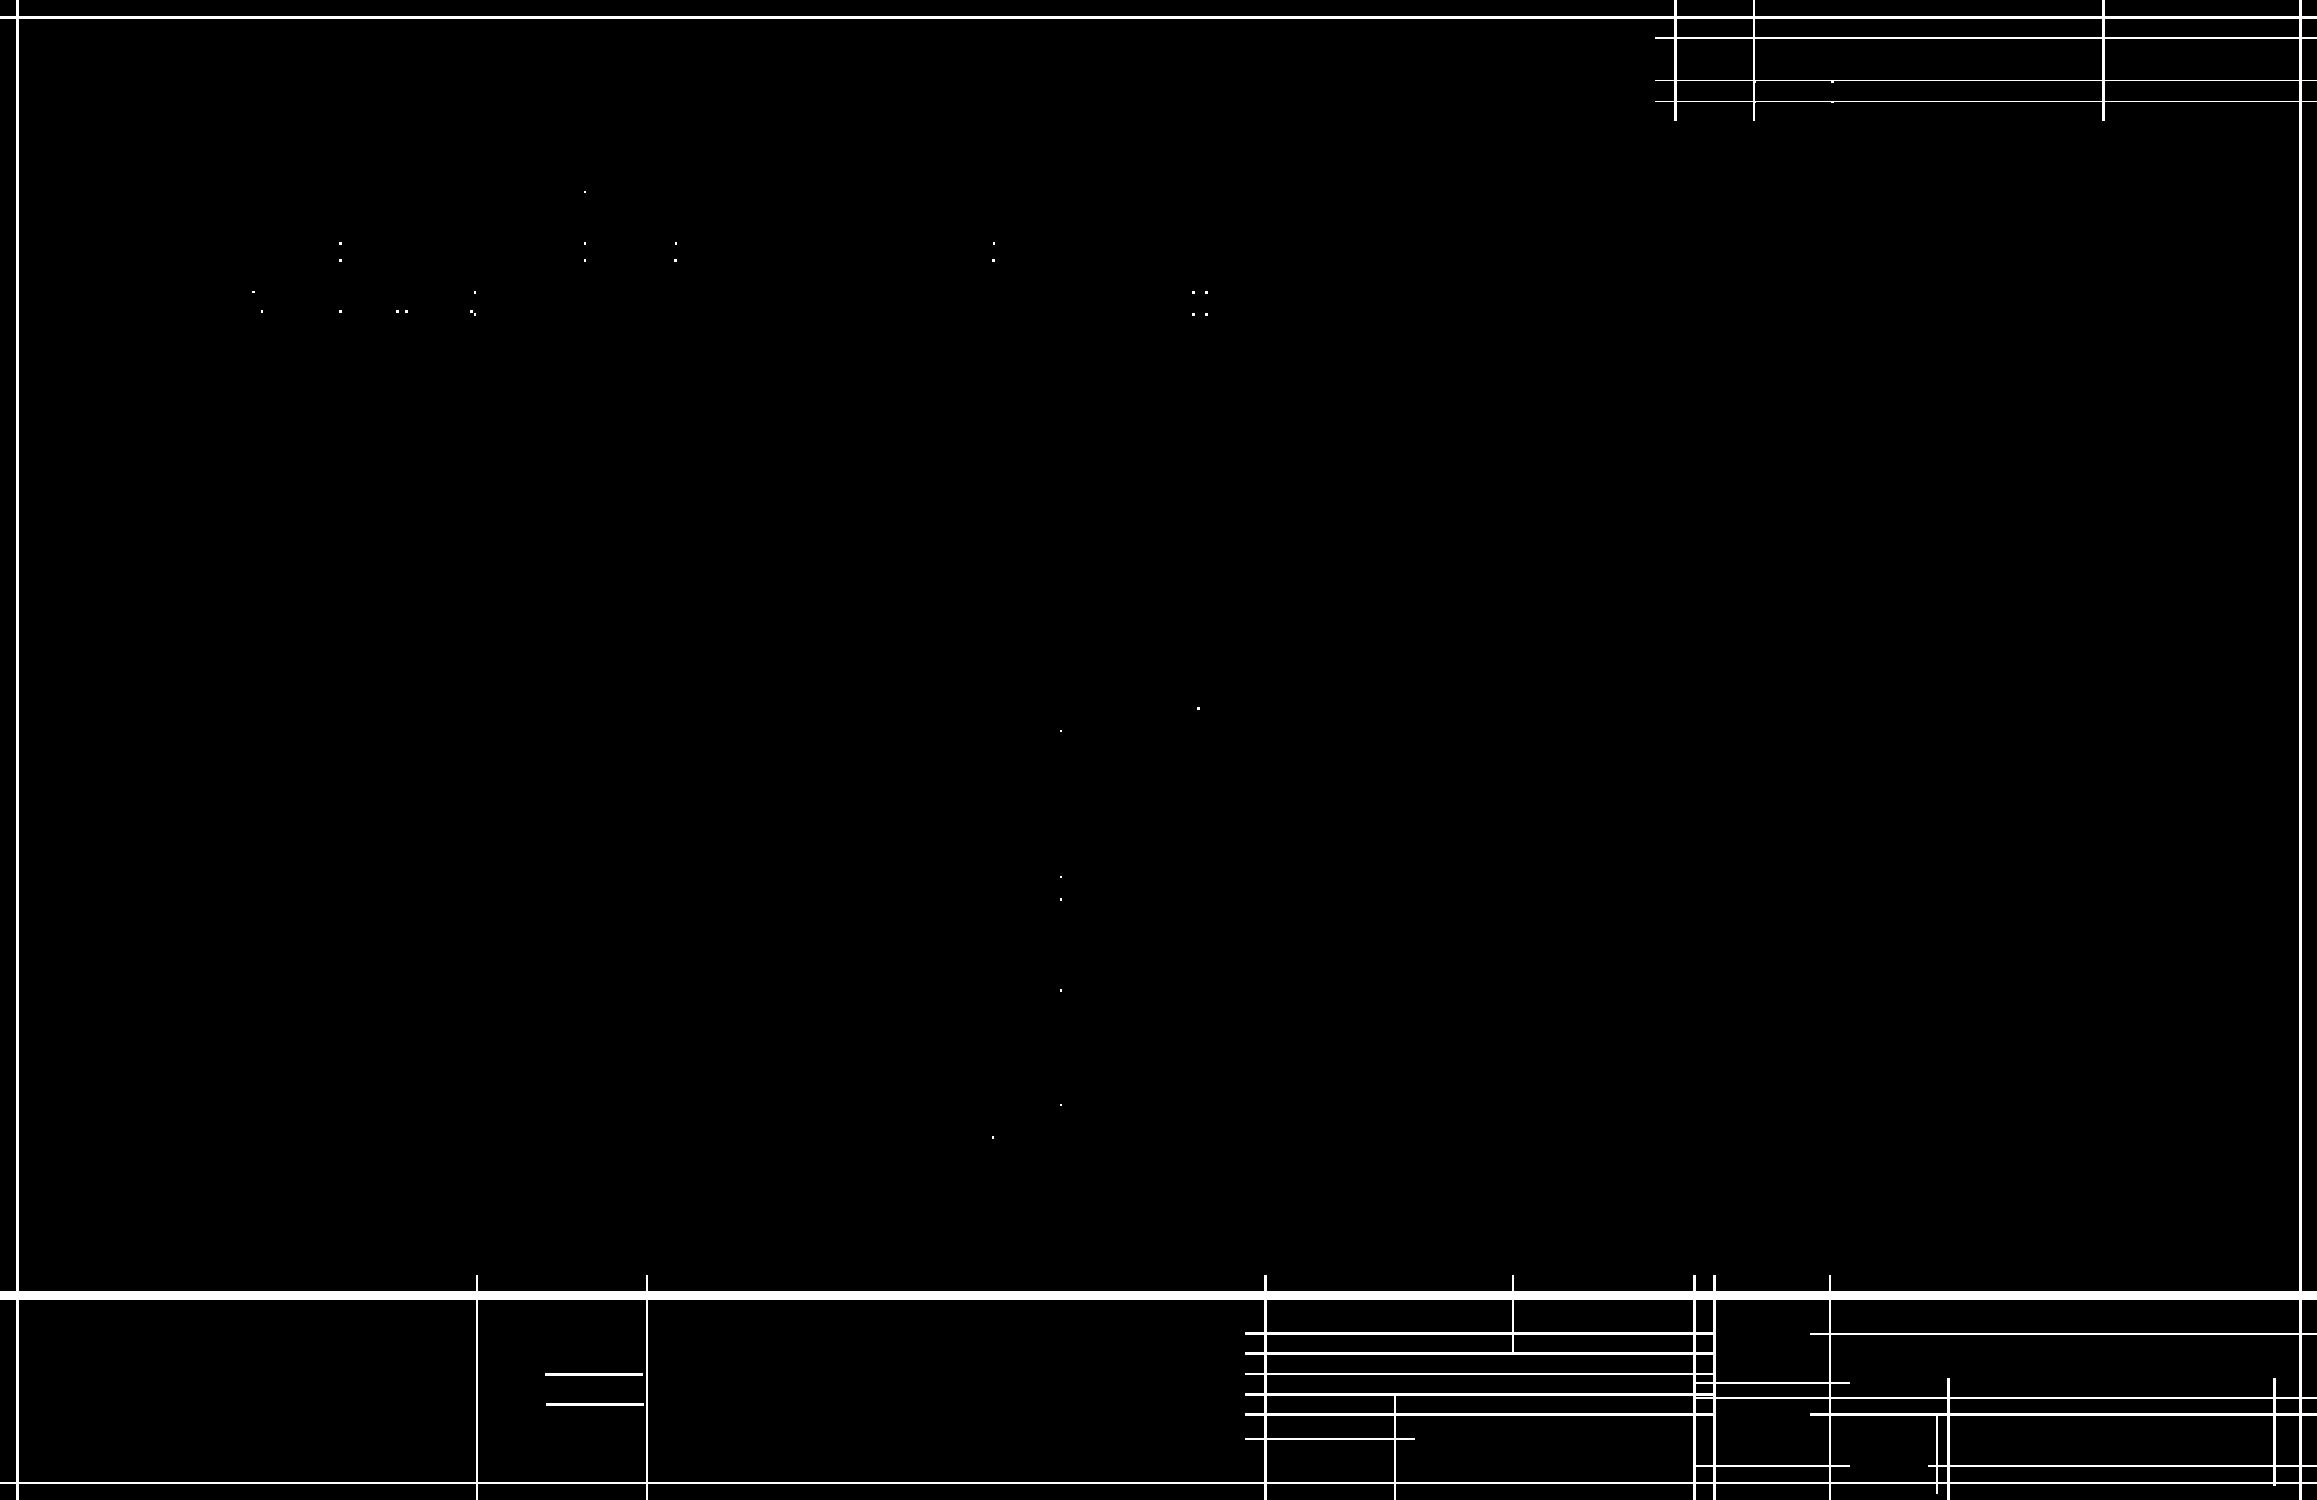

In [4]:
Image.fromarray(template)

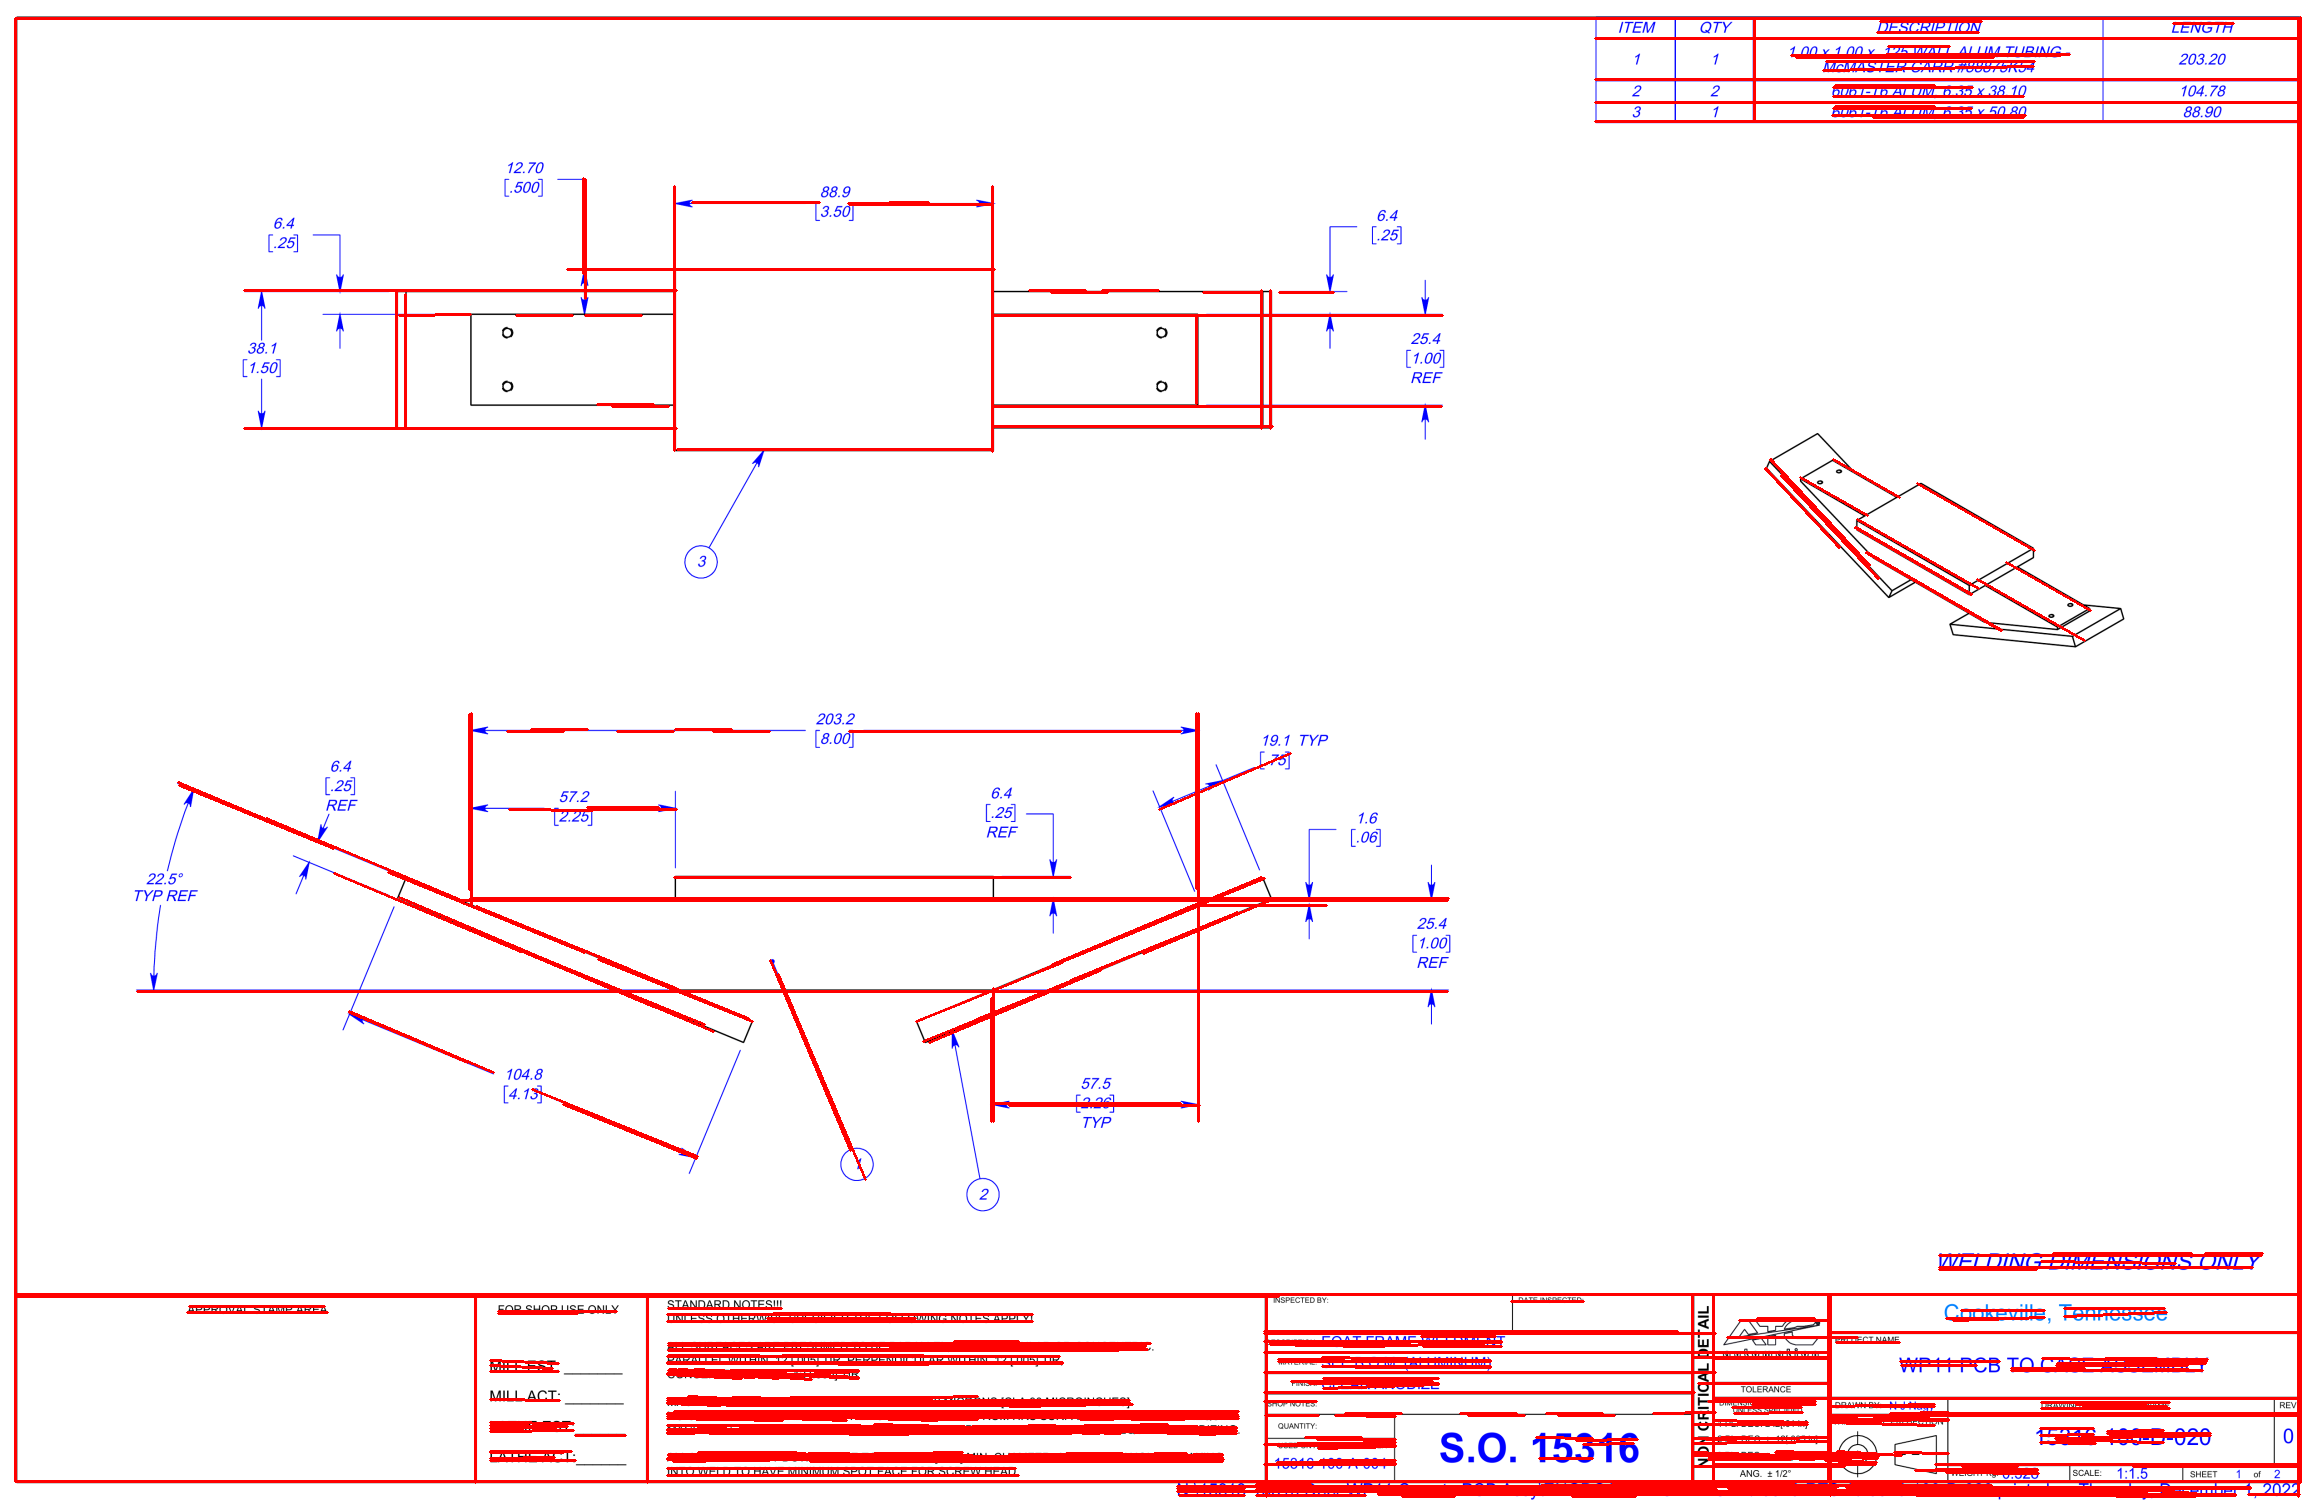

In [5]:
f, img, ocr_result, inner_border_lines, title_contours, line_90, sorted_indices, contours, hierarchy_area = image_data[1]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=100,
    minLineLength=50,
    maxLineGap=10
)
lines = remove_similar_lines(lines)

img_comp = img.copy()

for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)

In [6]:
mask = structures[0]

im_h, im_w, _ = img.shape
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)
contours = detect_text_tables(img, words, mask)

title_contours = title_contours + contours

boundary = get_boundary(border_1, border_2, inner_border_lines)
# title_boundary = get_title_boundary(boundary, line_90, title_contours, words, im_h)

template_boundaries = borders.copy()
template_boundaries[(template_boundaries[:, 1] > int((im_h * 70) / 100)) & (template_boundaries[:, 3] > int((im_h * 70) / 100)), 3] = boundary[0][1]
template_boundaries[(template_boundaries[:, 2] > int((im_h * 85) / 100)), 2] = boundary[1][0]
template_boundaries[(template_boundaries[:, 0] < int((im_h * 15) / 100)), 0] = boundary[0][0]
template_boundaries[(template_boundaries[:, 1] < int((im_h * 30) / 100)) & (template_boundaries[:, 3] < int((im_h * 30) / 100)), 1] = boundary[1][1]
# template_boundaries = template_boundaries[~(abs(template_boundaries[:, 1] - template_boundaries[:, 3]) < 5)]

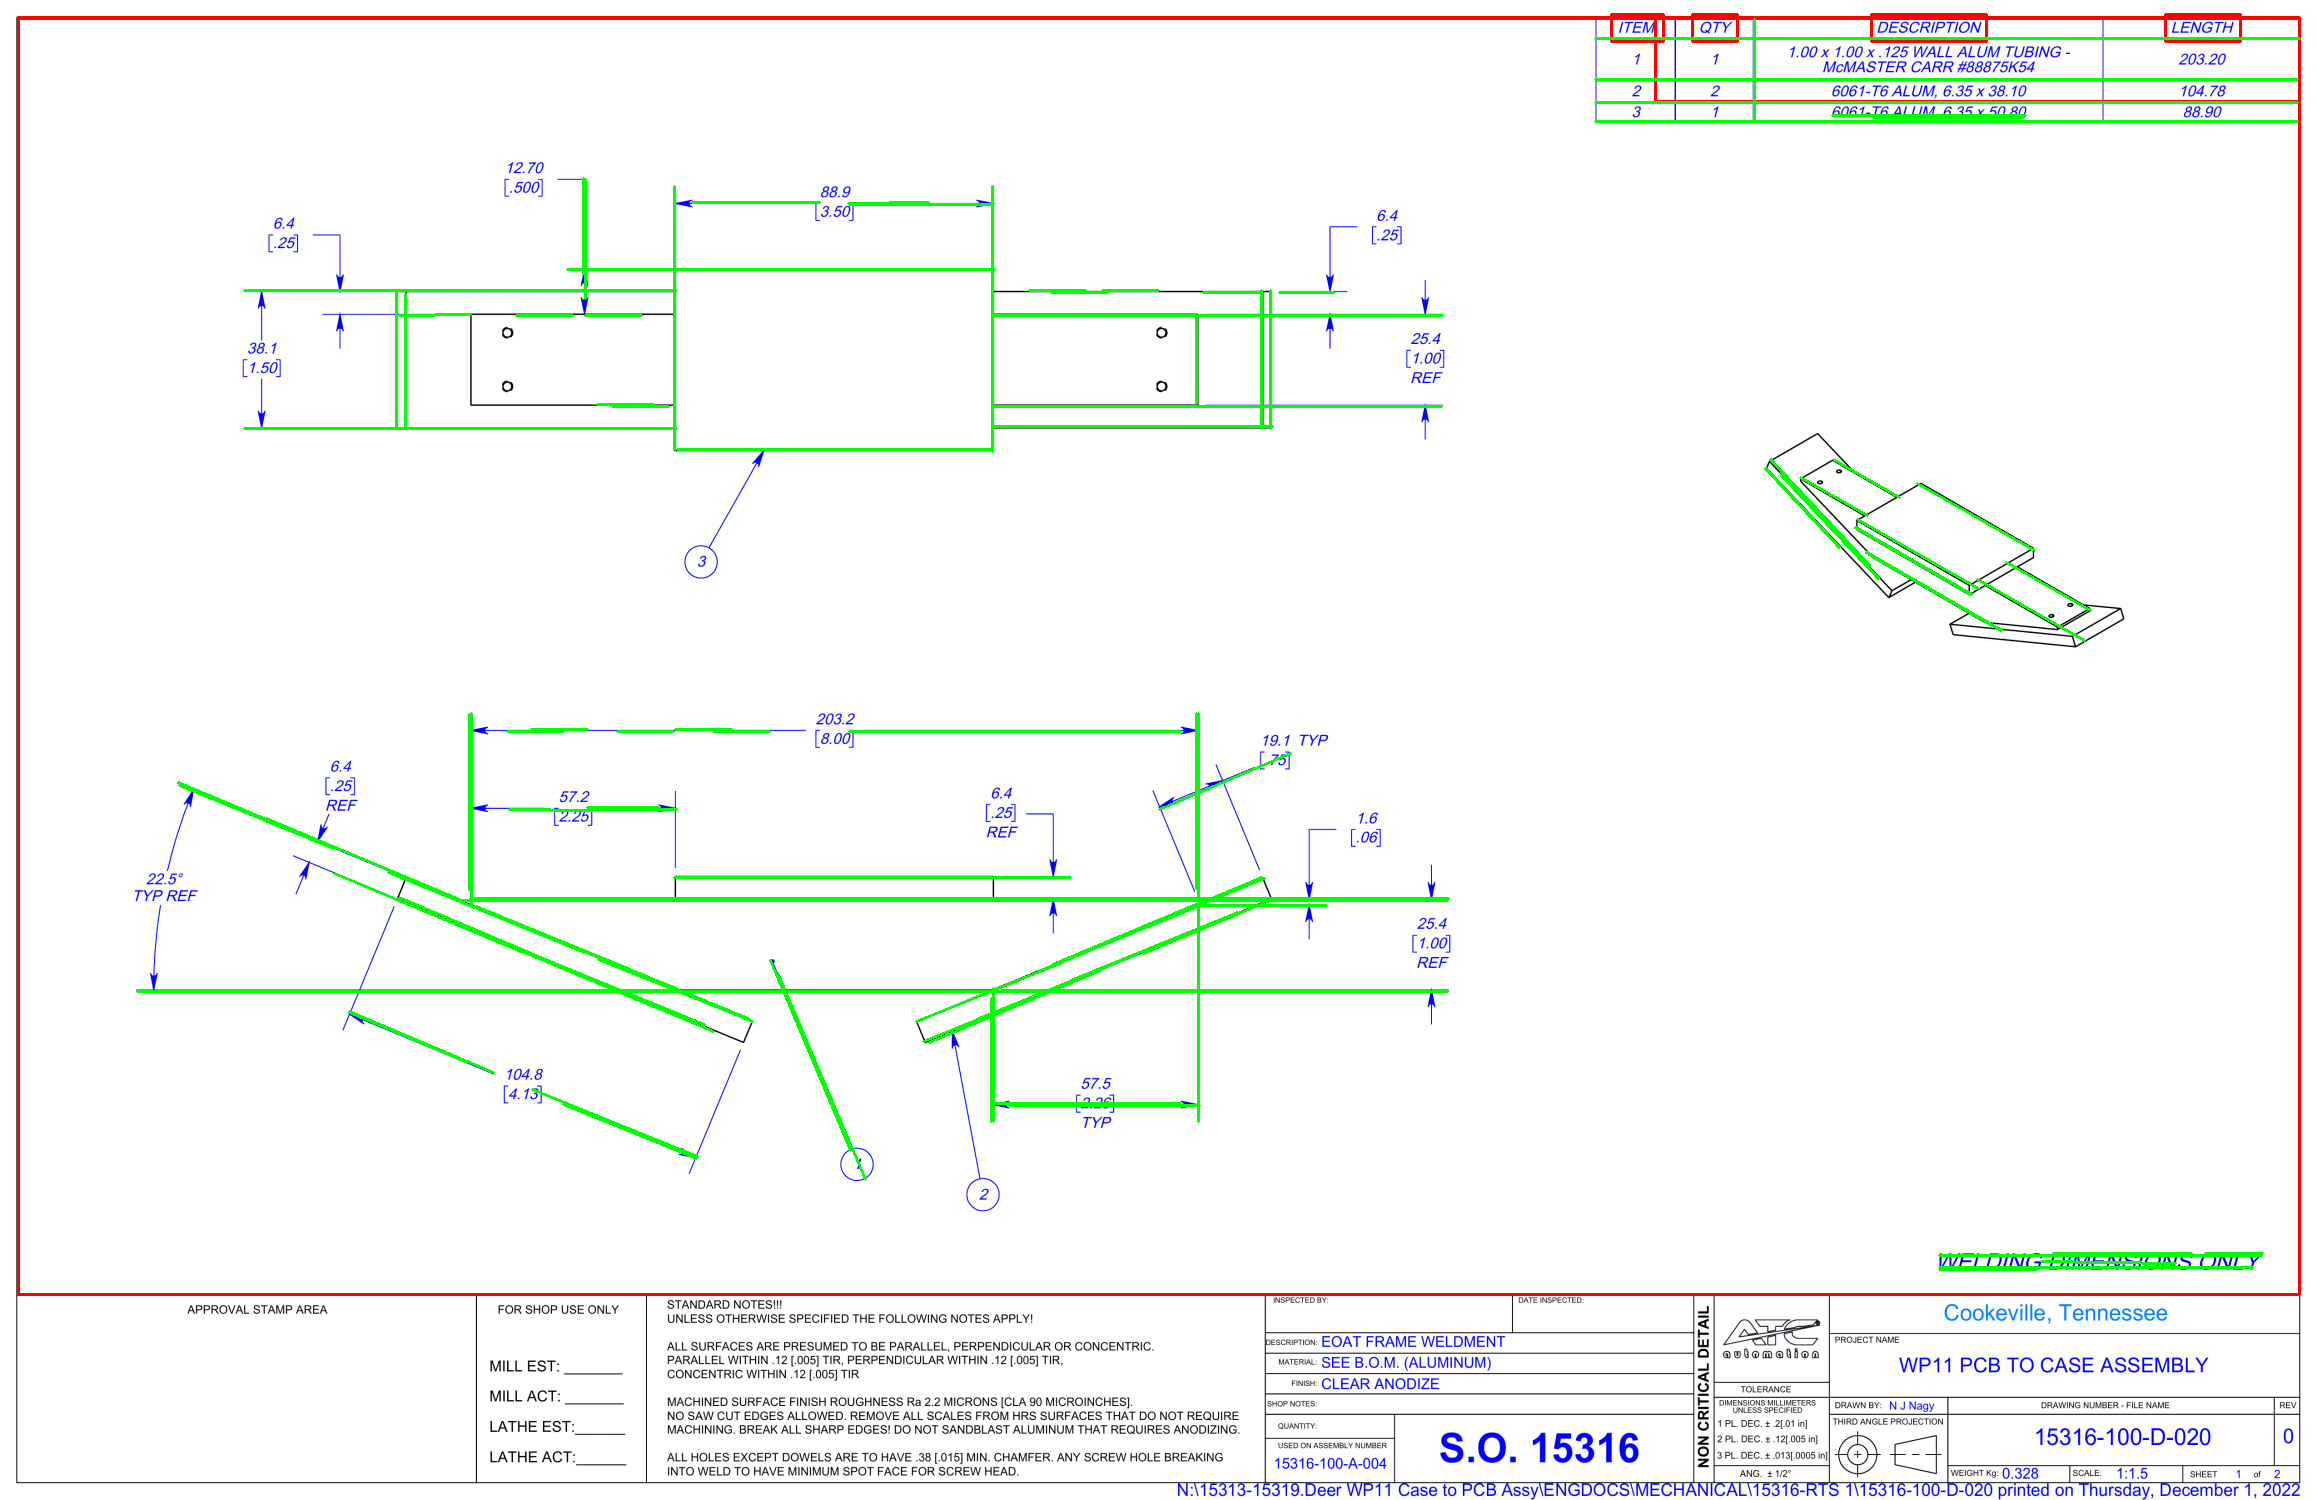

In [7]:
tolerance = 10
template_lines = []
drawings = lines.copy()
words_copy = words.copy()
(x1, y1), (x2, y2) = boundary.copy()
y2 += tolerance
y1 -= tolerance
x2 -= tolerance
x1 += tolerance

boundary_lines = [
    [x1, y2, x2, y2],  # Top
    [x1, y1, x2, y1],  # Bottom
    [x2, y2, x2, y1],  # Right
    [x1, y2, x1, y1],  # Left
]

(x1, y1), (x2, y2) = boundary
left = min(x1, x2)
right = max(x1, x2)
top = min(y1, y2)
bottom = max(y1, y2)

drawings = drawings[
    ~((drawings[:, 1] <= top + tolerance) & (drawings[:, 3] <= top + tolerance))
    & ~((drawings[:, 1] >= bottom - tolerance) & (drawings[:, 3] >= bottom - tolerance))
    & ~((drawings[:, 0] <= left + tolerance) & (drawings[:, 2] <= left + tolerance))
    & ~((drawings[:, 0] > right - tolerance) & (drawings[:, 2] > right - tolerance))
]

words_copy = words_copy.loc[
    ~words.value.isin(x_index_titles) &
    ~words.value.isin(y_index_titles)
]
words_copy = words_copy.loc[
    (words.x1 < boundary_lines[3][0]) & (words.x2 > boundary_lines[3][2])  # left
    | (words.x1 < boundary_lines[2][0]) & (words.x2 > boundary_lines[2][2])  # right
    | (words.y1 < boundary_lines[1][1]) & (words.y2 > boundary_lines[1][3])  # top
    | (words.y1 < boundary_lines[0][1]) & (words.y2 > boundary_lines[0][3])  # bottom
]
for b in template_boundaries:
    x1, y1, x2, y2 = b

    left = min(x1, x2)
    right = max(x1, x2)
    top = min(y1, y2)
    bottom = max(y1, y2)

    boundary_title_block_lines = [
        [left, top, right, top],  # Top
        [left, bottom, left, top],  # Left
        [right, bottom, right, top],  # Right
        [left, bottom, right, bottom],  # Bottom
    ]
    template_lines.extend(boundary_title_block_lines)

    drawings = drawings[
        ~(
                (drawings[:, 1] >= top - tolerance)
                & (drawings[:, 3] >= top - tolerance)
                & (drawings[:, 0] >= left - tolerance)
                & (drawings[:, 2] >= left - tolerance)
                & (drawings[:, 3] <= bottom + tolerance)
                & (drawings[:, 1] <= bottom + tolerance)
                & (drawings[:, 2] <= right + tolerance)
                & (drawings[:, 0] <= right + tolerance)
        )
    ]
    words_copy = words_copy.loc[
        (
            (words.x1 < boundary_title_block_lines[1][0])  # left
            | (words.y1 < boundary_title_block_lines[0][1])  # left
        )
    ]

img_comp = img.copy()

for idx, row in words_copy.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

for line in template_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

cv2.rectangle(img_comp, boundary[0], boundary[1], (255, 0, 0), thickness)

for line in drawings:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)

# cv2.rectangle(img_comp, title_boundary[0], title_boundary[1], (0, 255, 0), thickness)

Image.fromarray(img_comp)

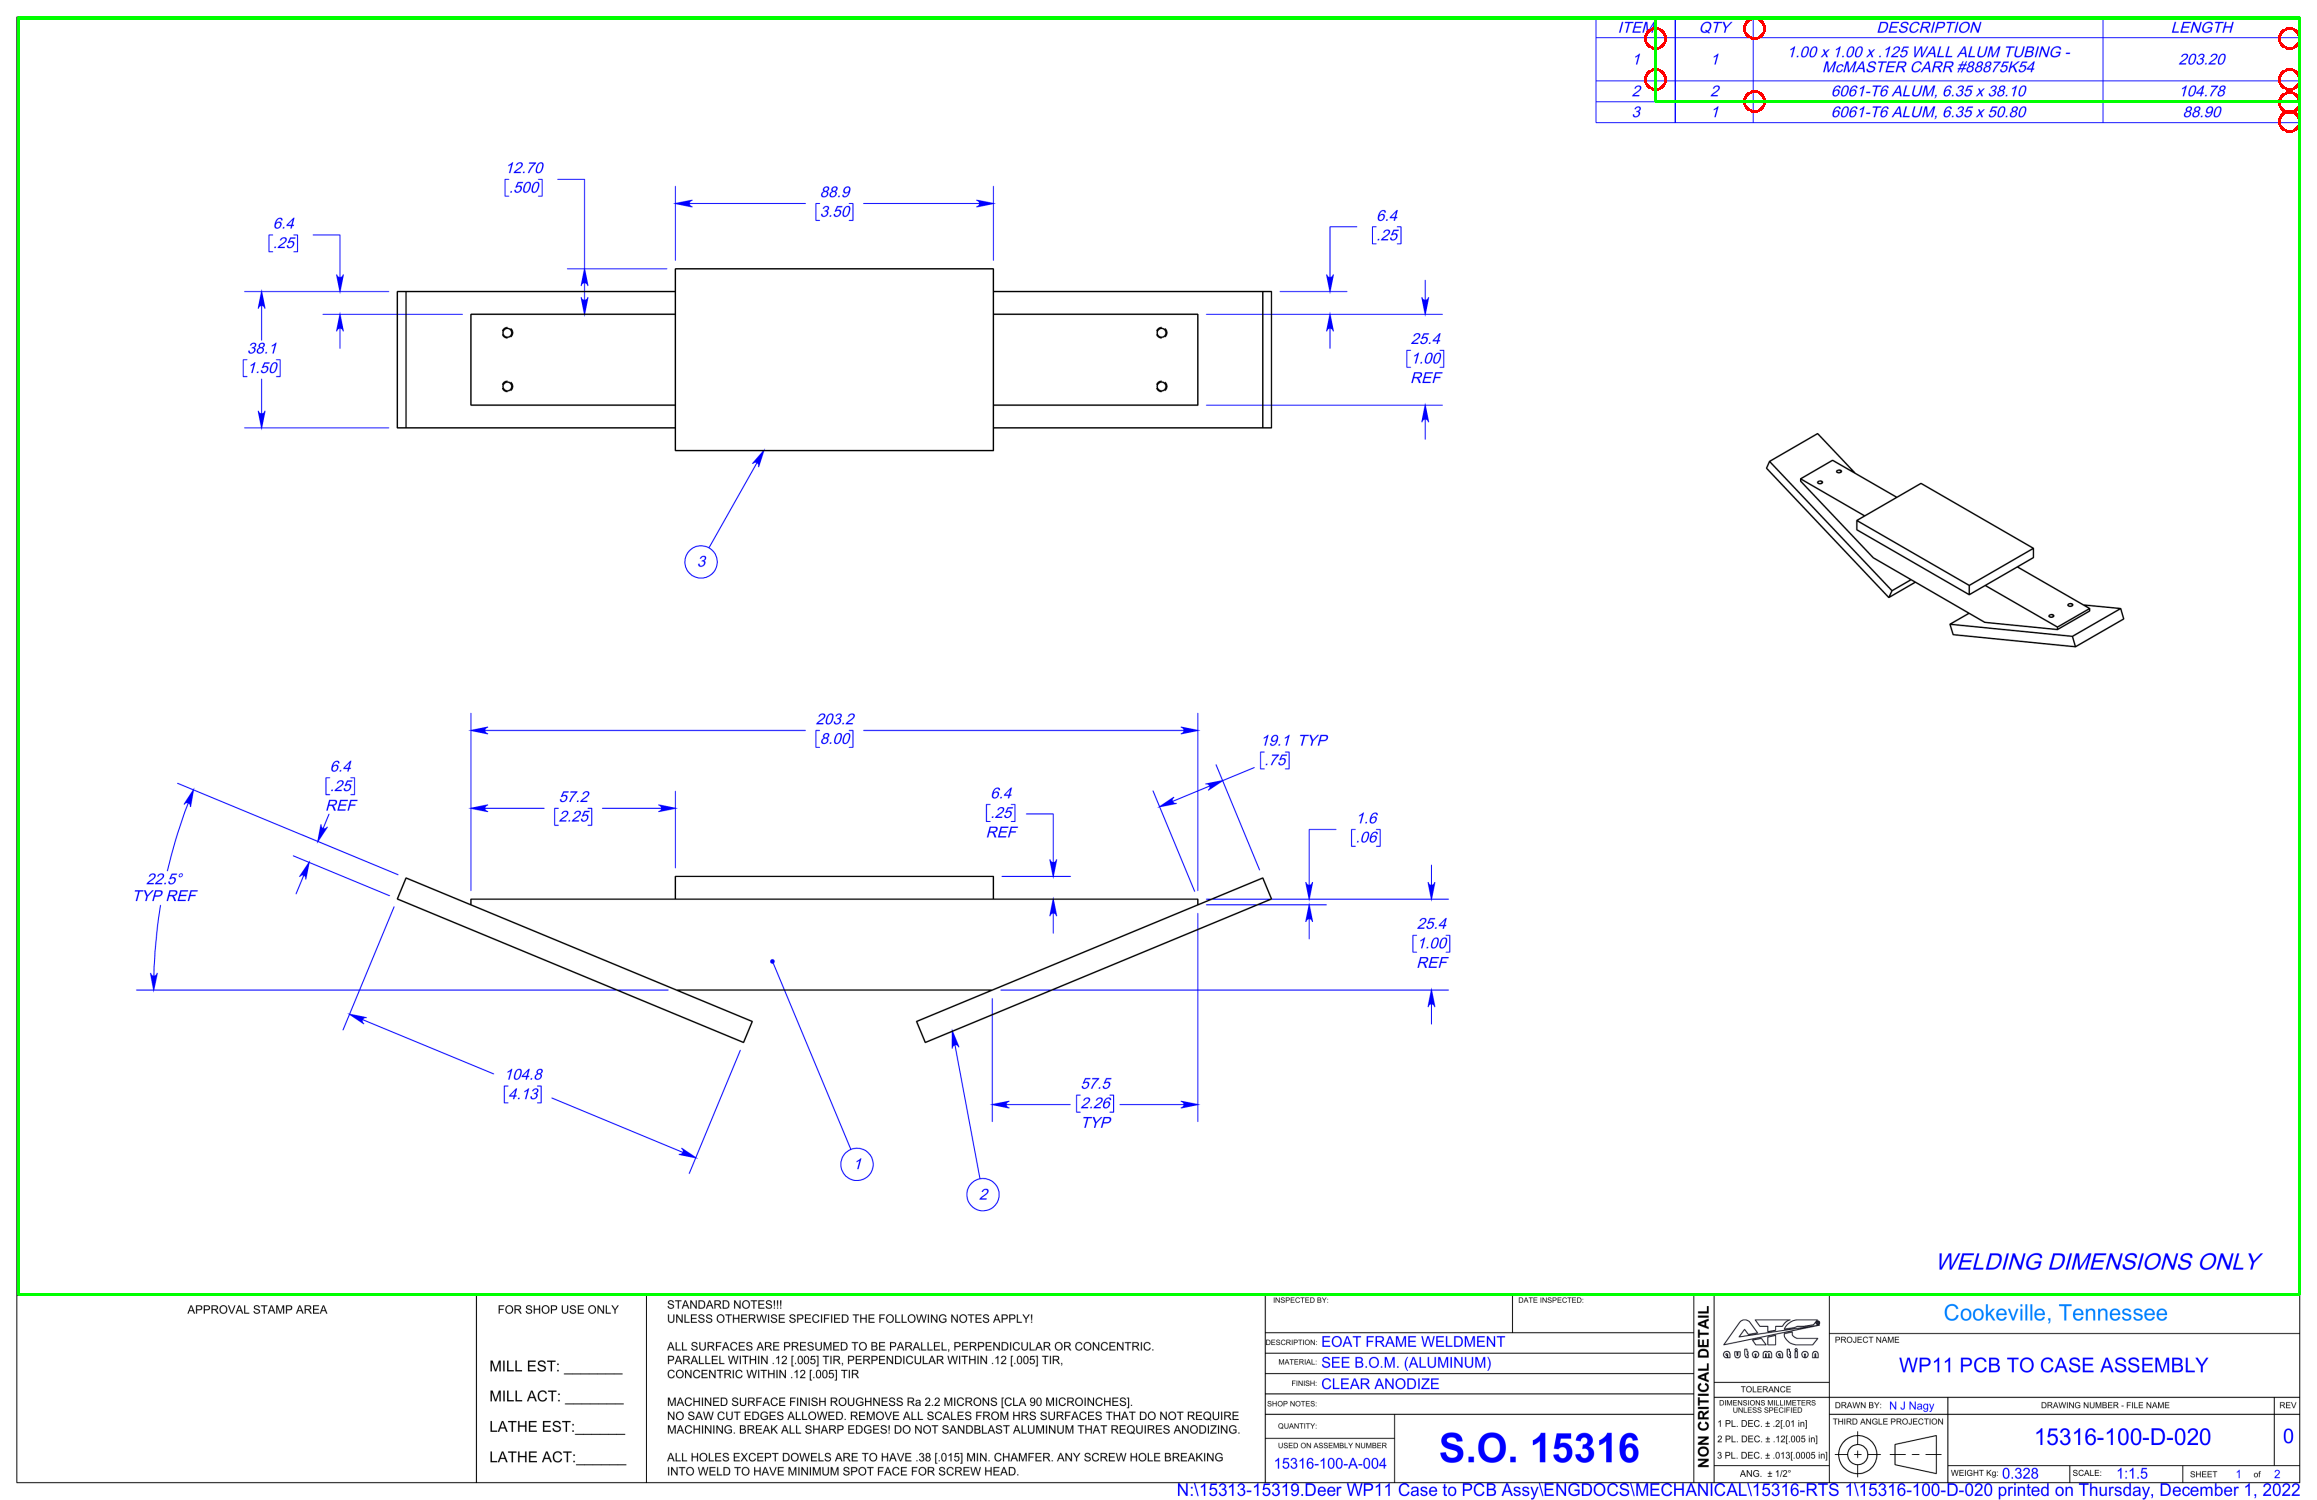

In [8]:
intersection_points = []
intersection_lines = []

for line in template_lines:
    intersected_lines, intersected_at = find_intersected_lines(line, drawings)
    intersection_points.extend(intersected_at)
    intersection_lines.extend(intersected_lines)

for line in boundary_lines:
    intersected_lines, intersected_at = find_intersected_lines(line, drawings)
    intersection_points.extend(intersected_at)
    intersection_lines.extend(intersected_lines)

img_comp = img.copy()

for point in intersection_points:
    x1, y1 = point
    cv2.circle(img_comp, (int(x1), int(y1)), 10, (255, 0, 0), 2)

for line in template_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2.rectangle(img_comp, boundary[0], boundary[1], (0, 255, 0), thickness)

Image.fromarray(img_comp)